In [1]:
#Import data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import cartesian
import numpy as np

#Import statistical tests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from sklearn.feature_selection import chi2

#Import machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Import visualisations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display

import pickle

In [2]:
#Import the data (only includes teams with more than 15 games played in that season)
data = pd.read_csv('final_data_30_days.csv', names = ['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency',
                                                      'o_efficiency', 'FGM', 'o_FGM', 'FGA', 'o_FGA', 'FG3M', 'o_FG3M', 'FG3A',
                                                      'o_FG3A', 'FTM', 'o_FTM', 'FTA', 'o_FTA', 'OREB', 'o_OREB', 'DREB',
                                                      'o_DREB', 'AST', 'o_AST', 'TOV', 'o_TOV', 'STL', 'o_STL', 'BLK', 'o_BLK',
                                                      'PF', 'o_PF',  'win_loss'])

## Data Exploration

Check for multicollinearity between columns. I removed any columns that had a variance inflation factor of greater than 5

In [3]:
X = data[['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency', 'o_efficiency', 'FGM', 'o_FGM', 'FGA', 'o_FGA',
          'FG3M', 'o_FG3M', 'FG3A', 'o_FG3A', 'FTM', 'o_FTM', 'FTA', 'o_FTA', 'OREB', 'o_OREB', 'DREB', 'o_DREB', 'AST',
          'o_AST', 'TOV', 'o_TOV', 'STL', 'o_STL', 'BLK', 'o_BLK', 'PF', 'o_PF']]

#Add a ones intercept as VIF library doesn't add one for you
X['intercept'] = 1

#Convert to numpy array as VIF library doesn't handle pandas dataframes
X2 = X.as_matrix()

#Compute VIF
vif = pd.DataFrame([variance_inflation_factor(X2, i) for i in range(X2.shape[1])], columns = ['VIF'])
vif['features'] =  X.columns

vif

,VIF,features
0,1.002728,home
1,1.658287,win_loss_ratio
2,1.622021,opposing_win_loss_ratio
3,1.392030,efficiency
4,1.403454,o_efficiency
5,3.323760,FGM
6,3.429196,o_FGM
7,4.716211,FGA
8,4.426284,o_FGA
9,16.202431,FG3M


There is a lot of multicollinearity between the columns. However, this should be expected as the field goal attempts and field goals made are directly influenced by each other. Dropping the `FGA`, `FG3A` and `FTM` columns results in a dataset that has less multicollinearity. Note that I dropped the `FTM` as opposed to  `FTA` since the opposing team does not influence a free throw shot

## Visualisations
### Outliers
Use boxplots to detect any anomalies in the data

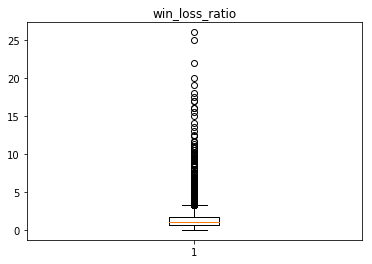

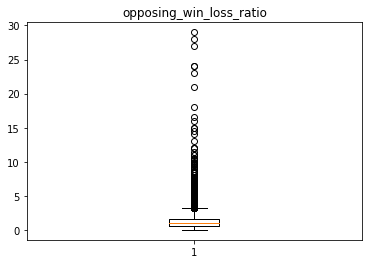

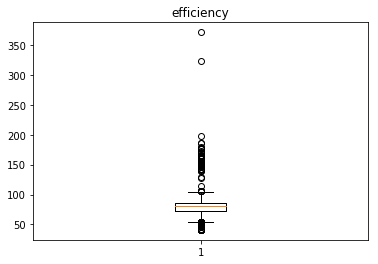

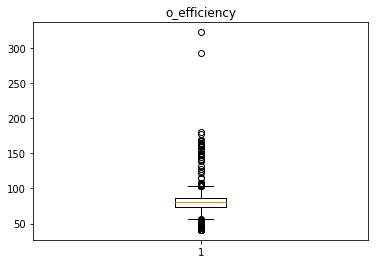

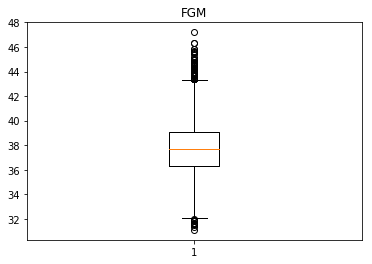

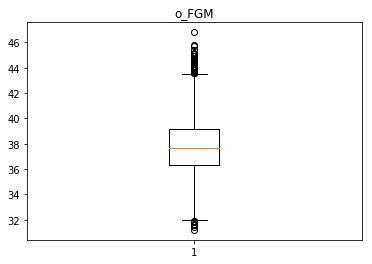

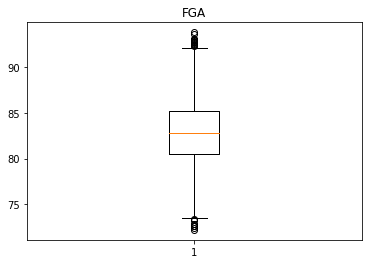

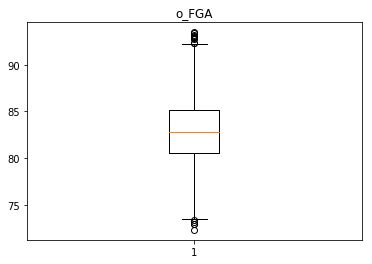

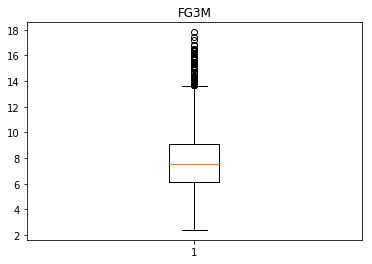

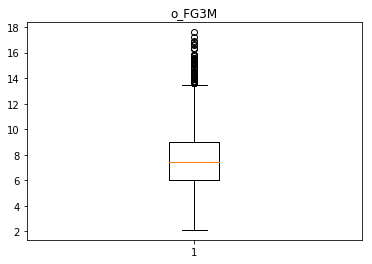

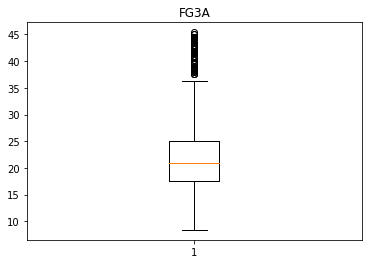

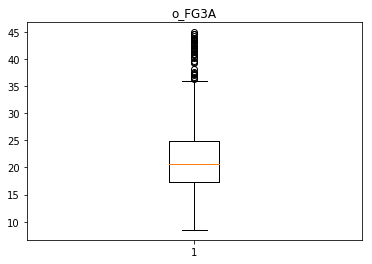

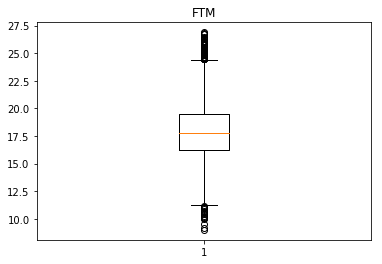

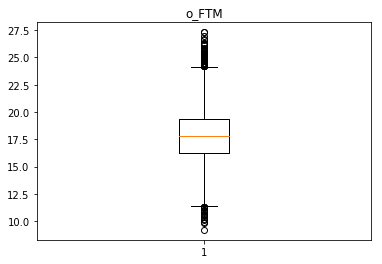

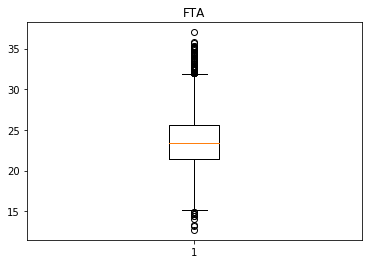

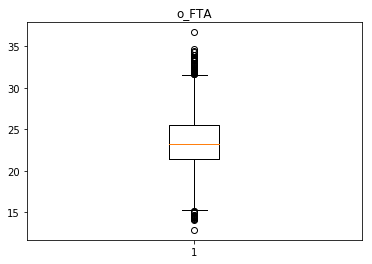

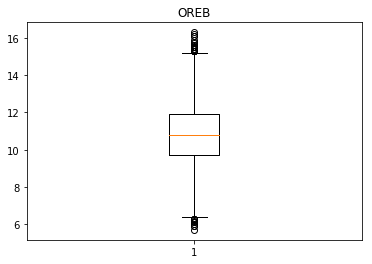

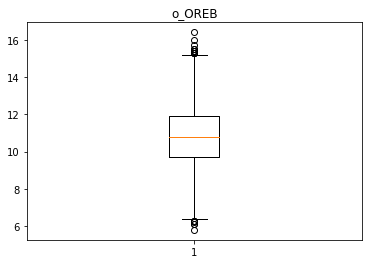

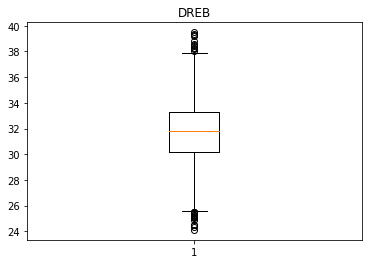

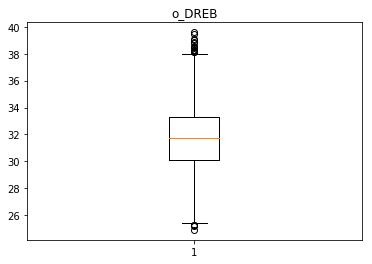

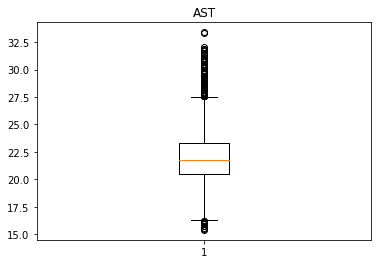

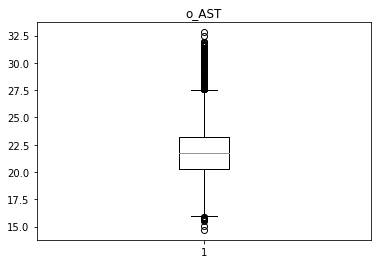

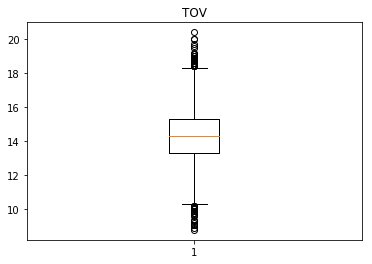

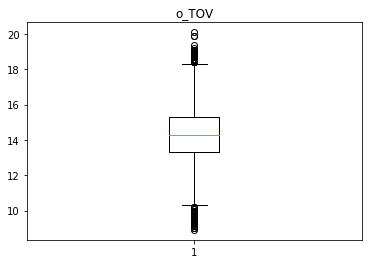

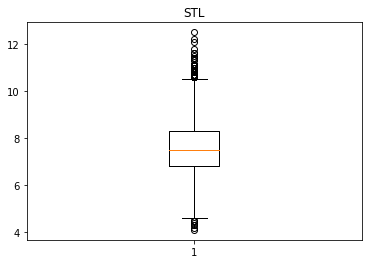

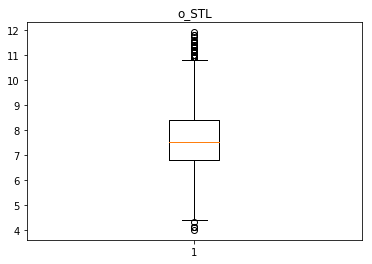

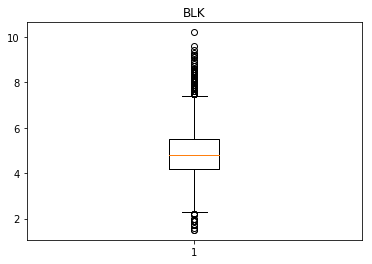

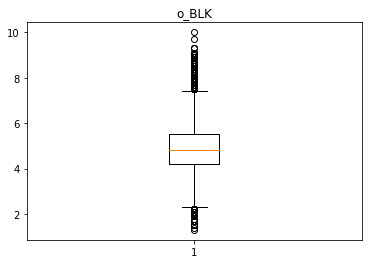

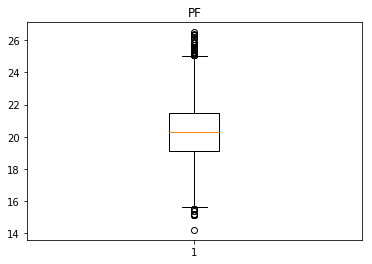

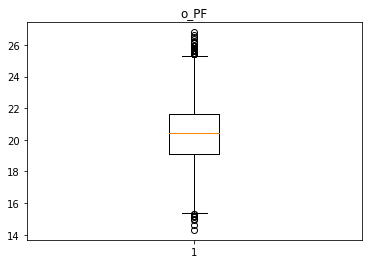

In [4]:
for word in data.columns:
    if word == 'home' or word == 'win_loss':
        continue
    plt.boxplot(data[word])
    plt.title(word)
    plt.show()

The `win_loss_ratio` and `efficiency` columns seem to have some outliers. The `win_loss_ratio` outliers are actually all from the Golden State Warriors during their historic 73-9 run. The other features seem to have a more normal distribution

In [5]:
#Drop the outliers
data.drop(data[data['win_loss_ratio'] > 20].index, inplace=True)
data.drop(data[data['opposing_win_loss_ratio'] > 20].index, inplace=True)
data.drop(data[data['efficiency'] > 300].index, inplace=True)
data.drop(data[data['o_efficiency'] > 300].index, inplace=True)

### Basic Sanity Check
Check that the binary `home` and `win_loss` columns have an approximately equal number of 0/1 observations 

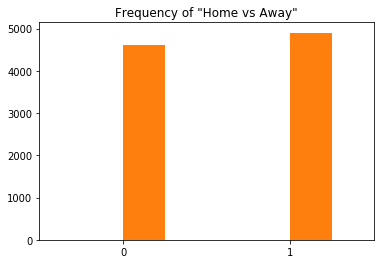

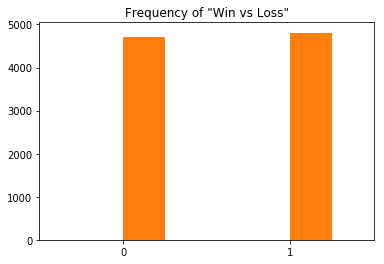

In [6]:
plot = data.groupby('home').size().reset_index(name='counts').plot(kind='bar', legend=False, title='Frequency of "Home vs Away"',
                                                                rot=0)
plot = data.groupby('win_loss').size().reset_index(name='counts').plot(kind='bar', title='Frequency of "Win vs Loss"', 
                                                                       legend=False, rot=0)

### Feature Significance
Use the Chi-Squared test to determine which features are actually significant for the classification. Any feature that has a p-value greater than 0.05 will not be used in the model. This data is already filtered on the highly collerated columns that I found before

In [7]:
X = data[['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency', 'o_efficiency', 'FGM', 'o_FGM', 'FG3M', 'o_FG3M',
          'FTA', 'o_FTA', 'OREB', 'o_OREB', 'DREB', 'o_DREB', 'AST', 'o_AST', 'TOV', 'o_TOV', 'STL', 'o_STL', 'BLK', 'o_BLK',
          'PF', 'o_PF']]
y = data['win_loss']
scores, pvalues = chi2(X, y)

p_values = pd.DataFrame(X.columns, columns=['Feature'])
p_values['P-Value'] = pd.DataFrame(pvalues).round(4)
p_values

,Feature,P-Value
0,home,0.0000
1,win_loss_ratio,0.0000
2,opposing_win_loss_ratio,0.0000
3,efficiency,0.0000
4,o_efficiency,0.0000
5,FGM,0.0071
6,o_FGM,0.0111
7,FG3M,0.0000
8,o_FG3M,0.0000
9,FTA,0.0073


## Modeling
### Finding the Right Model
Although not shown here, I tested Neural Networks, Random Forests, SVM, Logistic Regression and a Perceptron model. Out of all of these, the SVM with a linear kernal and Logistic Regression showed to be the most promising. I then iterated through any possible hyperparameters to find the optimal model

In [8]:
#Create a hyper parameter grid to test the models
log_param_grid = [
    {'C': [1, 0.1, 0.01, 0.001], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
    {'C': [1, 0.1, 0.01, 0.001], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag']},
 ]

svm_param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

In [10]:
#This statements lets me set the n_jobs=-1 which lets the algorithm use all cores for faster computation
if __name__ == '__main__':

    logistic = LogisticRegression()
    svm = SVC()

    #Divide the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(data[['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency',
                                                              'o_efficiency', 'FGM', 'o_FGM', 'FG3M', 'o_FG3M', 'FTA', 'o_OREB',
                                                              'DREB', 'o_DREB', 'AST', 'o_AST', 'TOV', 'o_TOV','STL', 'o_STL',
                                                              'BLK', 'o_PF']], data['win_loss'],
                                                        test_size=0.33)

    scores = ['accuracy', 'f1']

    #Iterate through the parameters to fit the best set
    for score in scores:

        #Using ten-fold cross validation, iterate through the parameters to find the best one
        log_search = GridSearchCV( estimator=logistic, param_grid=log_param_grid, cv=10, scoring=score, n_jobs=-1)
        log_search.fit(X_train, y_train)

        display('Logistic Regression-' + score)
        print('---------------------------')
        print('Best parameters:')
        print(log_search.best_params_)
        print("Detailed classification report:")
        y_true, y_pred = y_test, log_search.predict(X_test)
        print(classification_report(y_true, y_pred))
        print

        svm_search = GridSearchCV( estimator=svm, param_grid=svm_param_grid, cv=10, scoring=score, n_jobs=-1)
        svm_search.fit(X_train, y_train)

        print('SVM-' + score)
        print('---------------------------')
        print('Best parameters: ') 
        print(svm_search.best_params_)
        print("Detailed classification report:")
        y_true, y_pred = y_test, svm_search.predict(X_test)
        print(classification_report(y_true, y_pred))
    

'Logistic Regression-accuracy'

---------------------------
Best parameters:
{'penalty': 'l2', 'C': 1, 'solver': 'lbfgs'}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.67      0.65      0.66      1529
          1       0.68      0.69      0.68      1609

avg / total       0.67      0.67      0.67      3138


SVM-accuracy
---------------------------
Best parameters: 
{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.67      0.65      0.66      1529
          1       0.68      0.70      0.69      1609

avg / total       0.67      0.67      0.67      3138



'Logistic Regression-f1'

---------------------------
Best parameters:
{'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs'}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.67      0.66      0.66      1529
          1       0.68      0.69      0.69      1609

avg / total       0.67      0.67      0.67      3138


SVM-f1
---------------------------
Best parameters: 
{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.67      0.65      0.66      1529
          1       0.68      0.70      0.69      1609

avg / total       0.67      0.67      0.67      3138



Going forward, I'm going to be using the logistic regression model, rather than SVM as the accuracies are similar and the logistic regression model computes much faster than SVM. We can see that the precision, recall and f1 scores are all fairly similar to the accuracy, so nothing stands out here. With this is mind, I am going to train and interept a logistic regression model

In [11]:
logistic = LogisticRegression(solver='lbfgs', penalty='l2')

X = (data[['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency', 'o_efficiency', 'FGM', 'o_FGM', 'FG3M', 'o_FG3M', 
           'FTA', 'DREB', 'o_DREB', 'o_OREB', 'AST', 'o_AST', 'TOV', 'o_TOV', 'STL', 'o_STL', 'BLK', 'o_PF']])
y = data['win_loss']
     
#Compute accuracy using ten-fold cross validation to reduce the risk of overfitting
accuracy = cross_val_score(logistic, X, y, cv=10).mean()

#Create the model and display coefficients and accuracy
model = logistic.fit(X, y)
coefficients = pd.DataFrame(X.columns, columns=['Feature'])
coefficients['Coefficient'] = pd.DataFrame( model.coef_[0] )

print("Model accuracy: {} ".format(accuracy))
display(coefficients)

#Save the complex model for later use
filename = 'final_model_complex.sav'
pickle.dump(model, open(filename, 'wb'))

Model accuracy: 0.664243877453 


,Feature,Coefficient
0,home,0.887183
1,win_loss_ratio,0.296508
2,opposing_win_loss_ratio,-0.363683
3,efficiency,0.022551
4,o_efficiency,-0.023879
5,FGM,-0.023492
6,o_FGM,0.025623
7,FG3M,0.040315
8,o_FG3M,-0.044707
9,FTA,0.012902


The model accuracy is approximately 66.4%. Many models I have found online which try to also predict NBA game outcomes have accuracies which range from 60-70 percent accuracy. Thus my model accurate is on par with other research in this area 

It's easy to see that the `home` feature is the most important to determine whether a team is going to win or not. The `win_loss_ratio`'s are the next most important. To visualize the effects of these features, I'm going to generate data and plot the effect the top 5 features have on whether a team will win or lose. The following code was inspired by: http://blog.yhat.com/posts/logistic-regression-and-python.html

In [12]:
#Generate evenly spaced values for the top 5 most important features (exclude home since it's binary)
wn_lss_ratio = np.linspace(data['win_loss_ratio'].min(), data['win_loss_ratio'].max(), 10)
opp_wn_lss_ratio = np.linspace(data['opposing_win_loss_ratio'].min(), data['opposing_win_loss_ratio'].max(), 10)
blk = np.linspace(data['o_BLK'].min(), data['o_BLK'].max(), 10)
tov = np.linspace(data['TOV'].min(), data['TOV'].max(), 10)

# enumerate all possibilities, keeping the other features static
combos = pd.DataFrame(cartesian([ [0,1], wn_lss_ratio, opp_wn_lss_ratio, [79.8], [79.9], [37.7], [37.8], [7.7], [7.6], [23.6],
                                [31.8], [31.7], [10.8], [21.9], [21.9], tov, [14.3], [7.6], [7.6], blk, [20.4] ]))
combos.columns = ['home', 'win_loss_ratio', 'opposing_win_loss_ratio','efficiency', 'o_efficiency', 'FGM', 'o_FGM', 'FG3M',
                  'o_FG3M', 'FTA', 'DREB', 'o_DREB', 'o_OREB', 'AST', 'o_AST', 'TOV', 'o_TOV', 'STL', 'o_STL', 'BLK', 'o_PF']

#make predictions on the enumerated dataset
combos['wn_lss_prd'] = model.predict(combos)

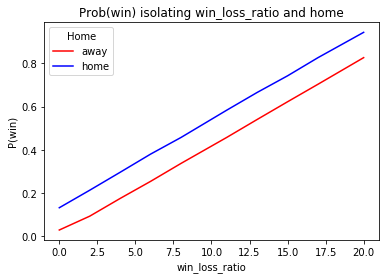

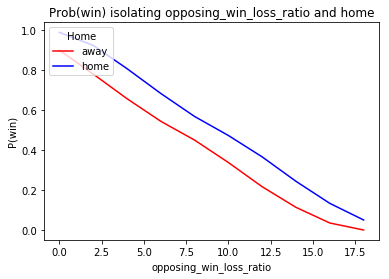

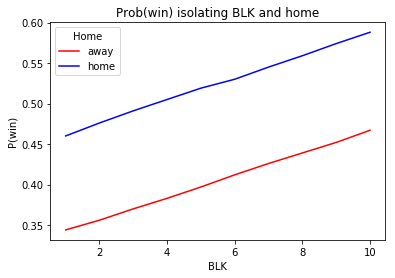

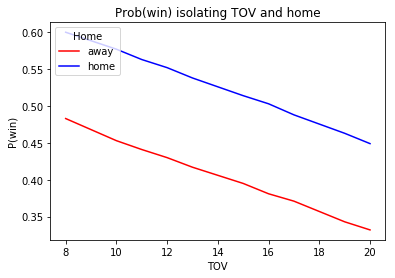

In [13]:
def isolate_and_plot(variable):
    #isolate everything but "home" and the chosen feature
    grouped = pd.pivot_table(combos, values=['wn_lss_prd'], index=[variable, 'home'],aggfunc=np.mean)
    
    #make a plot
    colors = 'rbgyrbgy'
    for col in combos.home.unique():
        plt_data = grouped.iloc [grouped.index.get_level_values(1)==col]
        plt.plot(plt_data.index.get_level_values(0), plt_data['wn_lss_prd'],
                color=colors[int(col)])

    plt.xlabel(variable)
    plt.ylabel("P(win)")
    plt.legend(['away', 'home'], loc='upper left', title='Home')
    plt.title("Prob(win) isolating " + variable + " and home")
    plt.show()

isolate_and_plot('win_loss_ratio')
isolate_and_plot('opposing_win_loss_ratio')
isolate_and_plot('BLK')
isolate_and_plot('TOV')

These plots are as expected, as your team has more wins, the liklihood of that team winning a game increases, the inverse is true when regarding the other team's win. In addition, the more blocks and less turnovers means likely means that a team is performing at a higher level, and is more likely to win a game. 

### Second Model
Since the first model uses in-season statistics, this data is not reliable until later on in the season. This simpler model is for use at the beginning of the season.

In [14]:
#Import the all the data
data = pd.read_csv('final_data_simple.csv', names = ['home','efficiency','o_efficiency', 'win_loss'])

In [15]:
#Search for the best hyperparameters for the simple model
if __name__ == '__main__':

    logistic = LogisticRegression()

    #Divide the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(data[['home', 'efficiency', 'o_efficiency']], data['win_loss'],
                                                        test_size=0.33)

    scores = ['accuracy', 'f1']

    #Iterate through the parameters to fit the best set
    for score in scores:

        #Using ten-fold cross validation, iterate through the parameters to find the best one
        log_search = GridSearchCV( estimator=logistic, param_grid=log_param_grid, cv=10, scoring=score, n_jobs=-1)
        log_search.fit(X_train, y_train)

        display('Logistic Regression-' + score)
        print('---------------------------')
        print('Best parameters:')
        print(log_search.best_params_)
        print("Detailed classification report:")
        y_true, y_pred = y_test, log_search.predict(X_test)
        print(classification_report(y_true, y_pred))
        print

'Logistic Regression-accuracy'

---------------------------
Best parameters:
{'penalty': 'l2', 'C': 0.01, 'solver': 'newton-cg'}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.64      0.59      0.61      2083
          1       0.62      0.67      0.65      2119

avg / total       0.63      0.63      0.63      4202




'Logistic Regression-f1'

---------------------------
Best parameters:
{'penalty': 'l2', 'C': 0.01, 'solver': 'lbfgs'}
Detailed classification report:
             precision    recall  f1-score   support

          0       0.64      0.58      0.61      2083
          1       0.62      0.67      0.65      2119

avg / total       0.63      0.63      0.63      4202




In [16]:
logistic = LogisticRegression(solver='newton-cg', penalty='l2', C=0.01)

X = data[['home', 'efficiency', 'o_efficiency']]
y = data['win_loss']
     
#Compute accuracy using ten-fold cross validation to reduce the risk of overfitting
accuracy = cross_val_score(logistic, X, y, cv=10).mean()
model = logistic.fit(X, y)

print("Model accuracy: {} ".format(accuracy))

#Save the model for later use
filename = 'final_model_simple.sav'
pickle.dump(model, open(filename, 'wb'))

Model accuracy: 0.625343700883 
